In [1]:
from src.models.vae import VAE
from src.trainer import CLEARVAETrainer
from src.utils.display_utils import interpolate_latent
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from corruption_utils import corruptions

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)
# mnist = torchvision.datasets.FashionMNIST("../data", train=True, download=True)

In [4]:
from src.utils.data_utils import StyledMNISTGenerator, StyledMNIST

In [5]:
def display_util(idx1, idx2, z: torch.Tensor, model: VAE, z_dim):
    with torch.no_grad():
        z1, z2 = z[idx1], z[idx2]
        display(transforms.ToPILImage()(model.decode(z1.view(1, -1))[0]))
        display(transforms.ToPILImage()(model.decode(z2.view(1, -1))[0]))
        z_inter = interpolate_latent(latent1=z1[z_dim:], latent2=z2[z_dim:], num_steps=11)
        z_combined = torch.cat([z1[:z_dim][None, :].repeat(11, 1), z_inter], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate style:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        z_inter = interpolate_latent(latent1=z1[:z_dim], latent2=z2[:z_dim], num_steps=11)
        z_combined = torch.cat([z_inter, z1[z_dim:][None, :].repeat(11, 1)], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate content:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()


In [6]:
np.random.seed(101)
torch.manual_seed(101)

In [9]:
generator = StyledMNISTGenerator(
    mnist,
    {
        lambda x: corruptions.rgb_change(x, "red"): 0.15,
        lambda x: corruptions.rgb_change(x, "green"): 0.25,
        lambda x: corruptions.rgb_change(x, "blue"): 0.15,
        lambda x: corruptions.rgb_change(x, "yellow"): 0.15,
        lambda x: corruptions.rgb_change(x, "cyan"): 0.2,
        lambda x: corruptions.rgb_change(x, "magenta"): 0.1,
    },
)


In [10]:
dataset = StyledMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:02<00:00, 22861.21item/s]


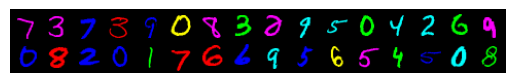

In [12]:
test_loader = DataLoader(test, batch_size=32, shuffle=False)

X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


In [29]:
X.dtype

torch.float32

Hamaguchi, et al. (2019) state that the distance/similarity metric between two Gaussians is recommended to take both the $\mu$ and the $\Sigma$ into account. However, these unexpectedly lead to blurring in reconstruction and in turn result in lower gMIG. Therefore, we use `cosine` and `l2` in the constrastive loss.

In [ ]:
Z_DIM = 8
TEMP = 10
ALPHA = 10
LABEL_FLIPPING = True

vae = VAE(total_z_dim=Z_DIM, in_channel=3).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CLEARVAETrainer(
    vae,
    optimizer,
    sim_fn="jeffrey",
    hyperparameter={"temperature": TEMP, "beta": 1/4, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [36]:
trainer.fit(41, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 182.33it/s]


val_recontr_loss=367.069, val_kl_c=11.883, val_kl_s=8.579, val_c_loss=0.441, val_s_loss=0.131
gMIG: 0.257; mse: 367.069


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 163.59it/s]


val_recontr_loss=146.388, val_kl_c=12.492, val_kl_s=9.725, val_c_loss=0.172, val_s_loss=0.132
gMIG: 0.317; mse: 146.388


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 196.02it/s]


val_recontr_loss=75.900, val_kl_c=12.261, val_kl_s=9.800, val_c_loss=0.146, val_s_loss=0.127
gMIG: 0.331; mse: 75.9


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 197.46it/s]


val_recontr_loss=48.236, val_kl_c=12.434, val_kl_s=9.823, val_c_loss=0.134, val_s_loss=0.127
gMIG: 0.327; mse: 48.236


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 207.80it/s]


val_recontr_loss=36.633, val_kl_c=11.910, val_kl_s=9.518, val_c_loss=0.132, val_s_loss=0.122
gMIG: 0.324; mse: 36.633


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 212.98it/s]


val_recontr_loss=30.264, val_kl_c=12.603, val_kl_s=9.420, val_c_loss=0.129, val_s_loss=0.118
gMIG: 0.335; mse: 30.264


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 219.56it/s]


val_recontr_loss=26.714, val_kl_c=12.517, val_kl_s=9.467, val_c_loss=0.125, val_s_loss=0.118
gMIG: 0.333; mse: 26.714


val-epoch 35: 100%|██████████| 79/79 [00:00<00:00, 191.37it/s]


val_recontr_loss=25.144, val_kl_c=12.321, val_kl_s=9.595, val_c_loss=0.119, val_s_loss=0.119
gMIG: 0.333; mse: 25.144


val-epoch 40: 100%|██████████| 79/79 [00:00<00:00, 209.62it/s]


val_recontr_loss=24.147, val_kl_c=12.407, val_kl_s=9.579, val_c_loss=0.124, val_s_loss=0.120
gMIG: 0.332; mse: 24.147


In [37]:
trainer.evaluate(test_loader, False, 0)

(0.3250585042216956, 24.41962432861328)

In [57]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


100%|██████████| 79/79 [00:00<00:00, 230.31it/s]


In [58]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

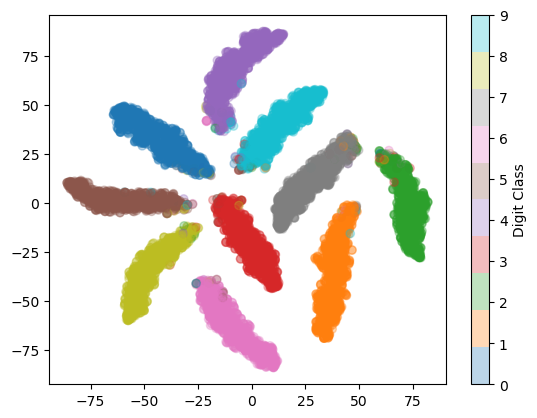

In [59]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

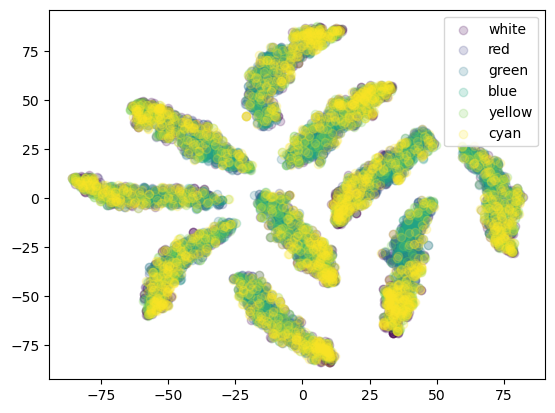

In [60]:
style_labels = ['white', 'red', 'green', 'blue', "yellow", 'cyan']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

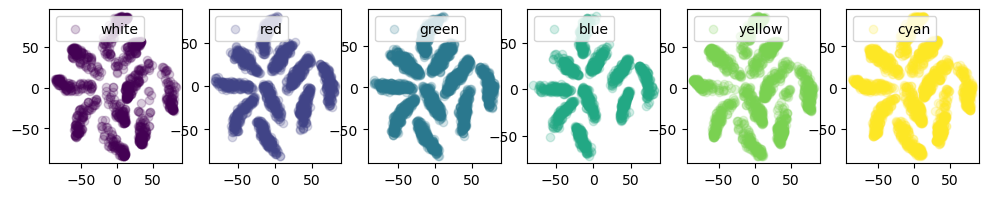

In [64]:
fig, axs = plt.subplots(1, 6, figsize=(12, 2))
for i, ax in enumerate(axs.flat):
    select = np.where(styles == i)[0]
    ax.scatter(mu_cs_tsne[select,0], mu_cs_tsne[select,1], alpha=0.2, 
               c=colors[i], label=style_labels[i])
    ax.legend(loc='upper left')

In [65]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

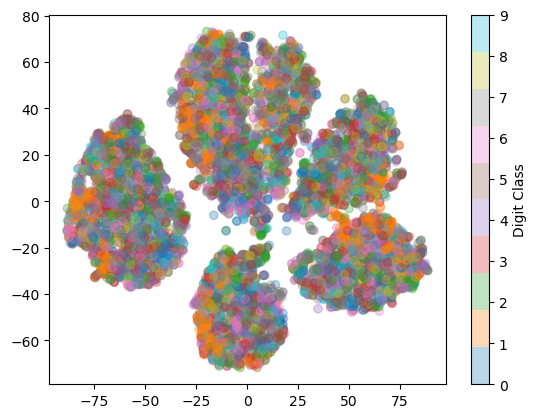

In [66]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

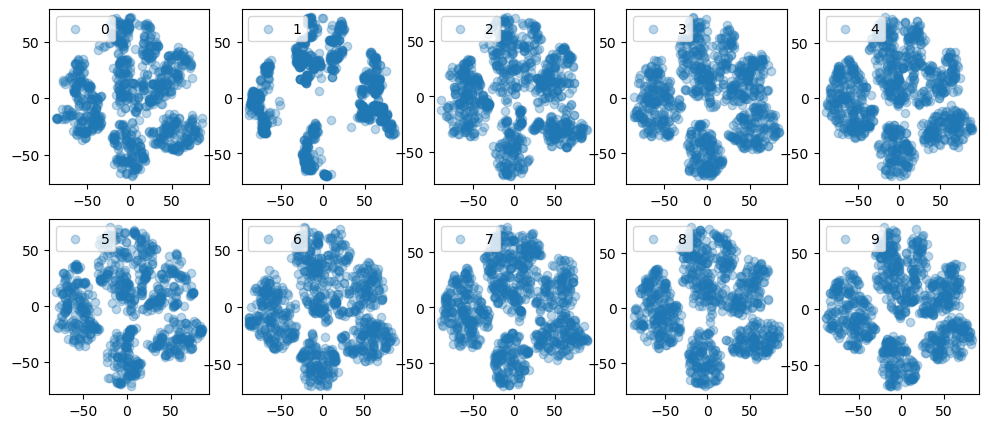

In [67]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3, label=f"{i}")
    ax.legend(loc='upper left')

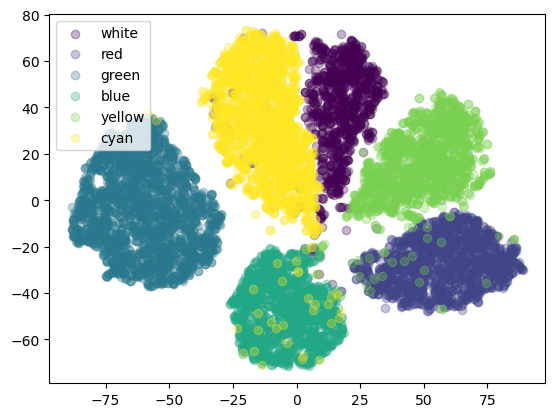

In [68]:
style_labels = ['white', 'red', 'green', 'blue', "yellow", 'cyan']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [86]:
test_loader = DataLoader(test, batch_size=128, shuffle=True)
X, c, s = next(iter(test_loader))
X = X.to(device)
vae.eval()
X_hat, latent_params, z = vae(X.clone(), explicit=True)


interpolate style:


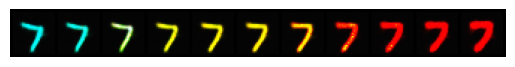

interpolate content:


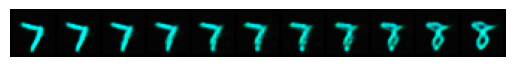

In [87]:
display_util(26, 9, z, vae, int(Z_DIM / 2))

interpolate style:


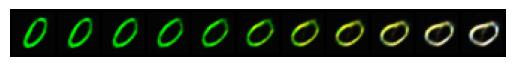

interpolate content:


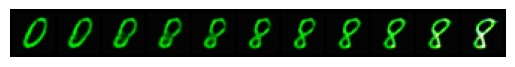

In [88]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

interpolate style:


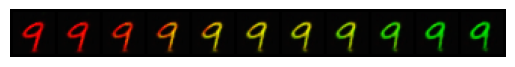

interpolate content:


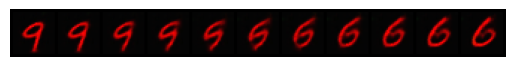

In [89]:
display_util(17, 30, z, vae, int(Z_DIM / 2))

interpolate style:


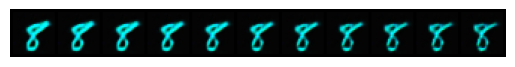

interpolate content:


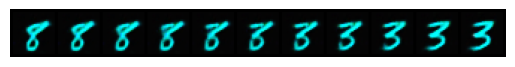

In [90]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

interpolate style:


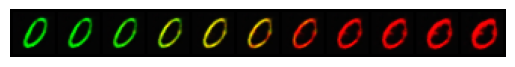

interpolate content:


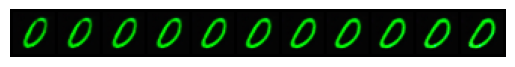

In [91]:
display_util(1, 31, z, vae, int(Z_DIM / 2))

In [76]:
idx = 1
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [77]:
for i in [53, 88, 62, 67, 73, 85, 71, 79, 98, 68]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))